In [1]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**1. Downloading the dataset**

In [3]:
data_folder = '/data/'
# Training Images and targets
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11763404.32it/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 170605.90it/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 569440.19it/s] 


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6094348.57it/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



In [4]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [5]:
# Validation Images and targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

**Inspect the tensors**

In [6]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY - {tr_targets.shape}\n\tY - Unique Values: {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


**Plot a random sample of 10 images for all the 10 possible classes**

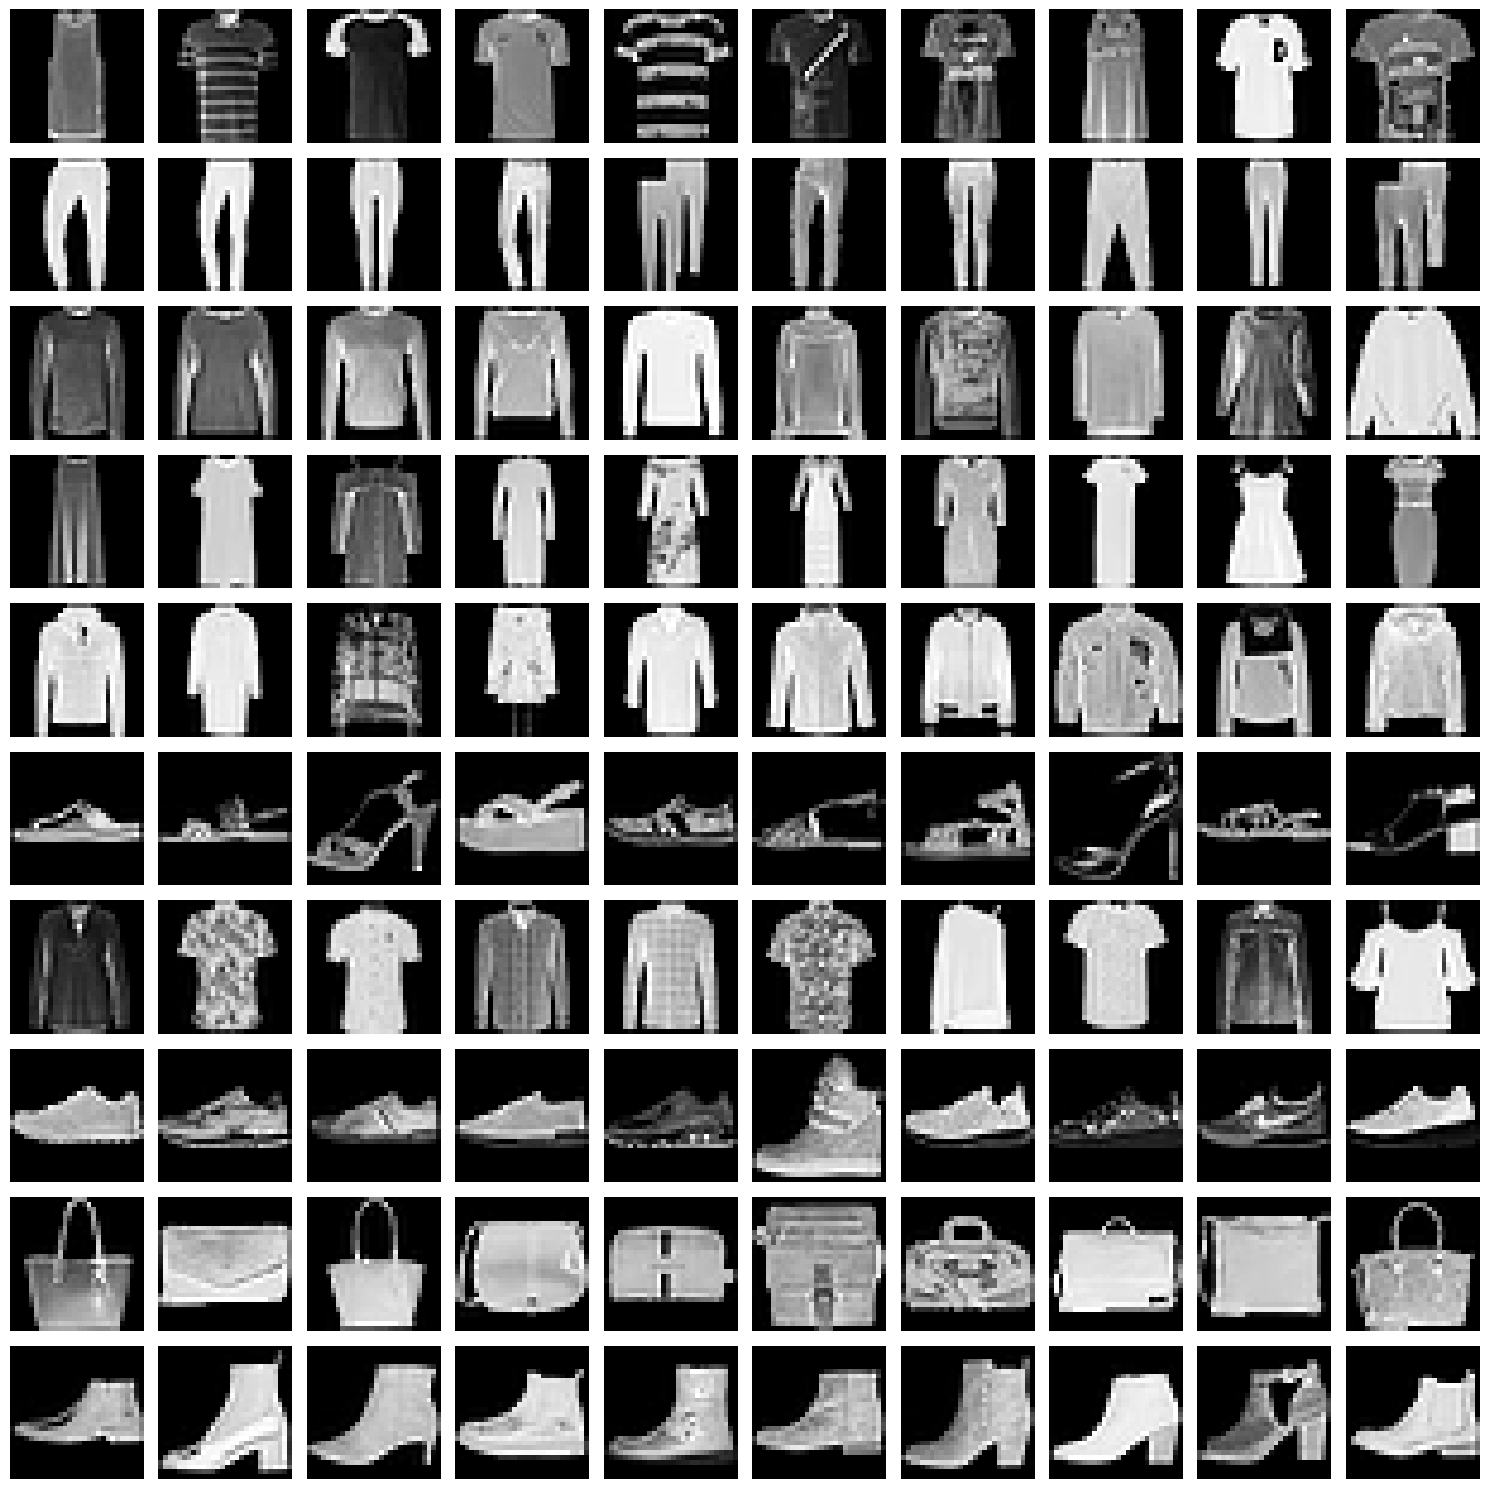

In [7]:
R, C = len(unique_values), 10
fig, ax = plt.subplots(R, C, figsize=(15, 15))

for label_class in range(len(unique_values)):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for col in range(C):
        plot_cell = ax[label_class, col]
        plot_cell.grid(False)
        plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x = tr_images[ix].numpy()
        plot_cell.imshow(x, cmap='gray')

plt.tight_layout()
plt.show()

**Build a class that fetches the dataset**

In [8]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()/255  # scaled
    x = x.view(-1, 28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

**Model**

In [9]:
def get_model():
  model = nn.Sequential(
      nn.Linear(28 * 28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
  ).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

**Train - on batch of images**

In [10]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction=model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

**Calculate Accuracy**

In [11]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    with torch.no_grad():
      prediction = model(x)
    # compute if the location of maximum in each row coincides
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [12]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)

  return trn_dl, val_dl

**Loss of validation data**

In [13]:
@torch.no_grad()
def val_loss(x, y, model):
  model.eval()
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

**Training Neural Network**

In [14]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [15]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
      x, y = batch
      val_is_correct = accuracy(x, y, model)
      validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)


    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


**Loss and Accuracy plots**

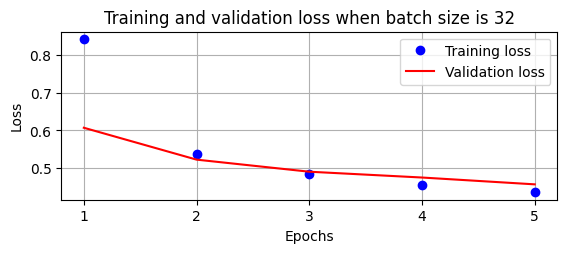

<ipython-input-16-56b6d7971bdf>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


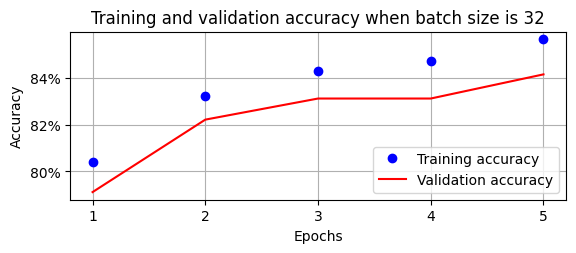

In [16]:
epochs = np.arange(5)+1

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
 label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
 label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
 for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()